# Training a CNN using Backpropagation
The following code implements a variant of the popular convolutional neural network, LeNet-5, using the TensorFlow Core API on the MNIST dataset.

## 1 Loading the Data
The dataset contains images of 60,000 handwritten digits for training and 10,000 for testing.

In [1]:
# Importing libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2023-08-12 09:23:23.766583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 09:23:23.840087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 09:23:23.841481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 09:23:24.927273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Printing shapes
print("Shape of x_train:",x_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [4]:
x_train = x_train.reshape((60000,28,28,1)).astype(float)
y_train = y_train.reshape((60000,1))
x_test = x_test.reshape((10000,28,28,1)).astype(float)
y_test = y_test.reshape((10000,1))

Label: [8]


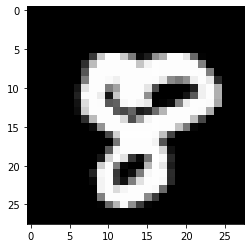

In [5]:
i = np.random.randint(0,60000)
print("Label:",y_train[i,:])
plt.imshow(x_train[i,:,:,:],cmap='gray')

## 2 Defining a Data Generator

In [6]:
batch_size = 64

def gen_batch(x,y,batch_size):
    batch_num = y.shape[0]//batch_size if y.shape[0]%batch_size == 0 else y.shape[0]//batch_size + 1
    i = 0
    
    while True:
        x_batch = x[batch_size*i:batch_size*(i+1),:,:]
        y_batch = y[batch_size*i:batch_size*(i+1),:]
        yield x_batch,y_batch
        i = (i + 1)%batch_num

## 3 Training the CNN using Backpropagation

In [7]:
# Initialising the paramaters of the neural network with Xavier initialisation
W1, W2, W3, W4, W5 = tf.random.normal((5,5,1,6))*tf.math.sqrt(1/25),tf.random.normal((5,5,6,16))*tf.math.sqrt(1/150),tf.random.normal((120,256))*tf.math.sqrt(1/256),tf.random.normal((84,120))*tf.math.sqrt(1/120),tf.random.normal((10,84))*tf.math.sqrt(1/84)
b1, b2, b3, b4, b5 = tf.zeros((1,6)),tf.zeros((1,16)),tf.zeros((120,1)),tf.zeros((84,1)),tf.zeros((10,1))

W1, W2, W3, W4, W5 = tf.Variable(W1), tf.Variable(W2), tf.Variable(W3), tf.Variable(W4), tf.Variable(W5)
b1, b2, b3, b4, b5 = tf.Variable(b1), tf.Variable(b2), tf.Variable(b3), tf.Variable(b4), tf.Variable(b5)

In [8]:
# Initialising the optimiser
optimizer = tf.keras.optimizers.Adam()

In [9]:
# Defining a function to calculate cost
def cost_fn():

    # Layer 1 (Conv 1 + Pool 1)
    Z1 = tf.nn.conv2d(x_batch,W1,1,'VALID') + b1
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,2,2,'VALID')

    # Layer 2 (Conv 2 + Pool 2)
    Z2 = tf.nn.conv2d(P1,W2,1,'VALID') + b2
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,2,2,'VALID')
    
    # Flatten
    F = tf.transpose(tf.reshape(P2,(x_batch.shape[0],-1)))

    # Layer 3 (FC 1)
    Z3 = W3@F + b3
    A3 = tf.nn.relu(Z3)

    # Layer 4 (FC 2)
    Z4 = W4@A3 + b4
    A4 = tf.nn.relu(Z4)

    # Layer 5 (Softmax)
    Z5 = W5@A4 + b5

    cost = 1/y_batch.shape[0]*tf.reduce_sum(tf.keras.metrics.sparse_categorical_crossentropy(y_batch,tf.transpose(Z5),True))

    return cost

In [10]:
# Training the model
iter = 1000
cost = np.array([])

gen = gen_batch(x_train,y_train,batch_size)

for i in np.arange(iter):
        x_batch,y_batch = next(gen)
        optimizer.minimize(cost_fn,[W1, W2, W3, W4, W5, b1, b2, b3, b4, b5])
        cost = np.append(cost,cost_fn())
        
gen.close()

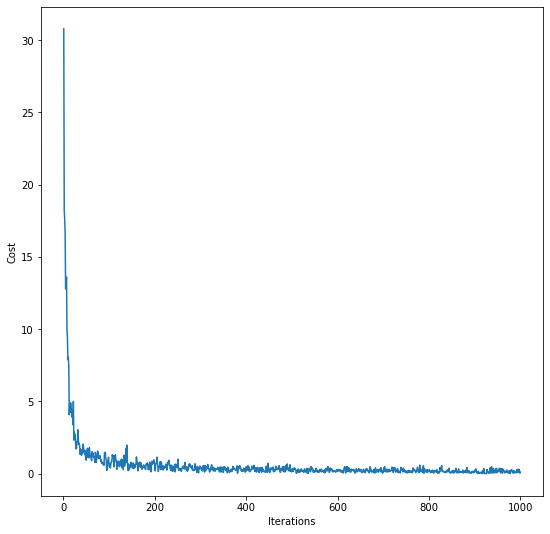

In [11]:
fig = plt.figure(figsize=[9,9])
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(iter)+1,cost)
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
fig.show()

## 4 Evaluating the Model on the Training Set

In [12]:
# Defining a function to predict the label of an image
def predict(x_batch):
    
    # Layer 1 (Conv 1 + Pool 1)
    Z1 = tf.nn.conv2d(x_batch,W1,1,'VALID') + b1
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,2,2,'VALID')

    # Layer 2 (Conv 2 + Pool 2)
    Z2 = tf.nn.conv2d(P1,W2,1,'VALID') + b2
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,2,2,'VALID')
    
    # Flatten
    F = tf.transpose(tf.reshape(P2,(x_batch.shape[0],-1)))

    # Layer 3 (FC 1)
    Z3 = W3@F + b3
    A3 = tf.nn.relu(Z3)

    # Layer 4 (FC 2)
    Z4 = W4@A3 + b4
    A4 = tf.nn.relu(Z4)

    # Layer 5 (Softmax)
    Z5 = W5@A4 + b5
    A5 = tf.nn.softmax(Z5)

    labels = tf.reshape(tf.math.argmax(A5,0),(-1,1))

    return labels

In [13]:
predict(x_train[0:16])

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 9, 5, 3, 6, 1, 7])>

In [14]:
y_train[0:16]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4],
       [3],
       [5],
       [3],
       [6],
       [1],
       [7]], dtype=uint8)